<a href="https://colab.research.google.com/github/hecshzye/nlp-medical-abstract-pubmed-rct/blob/main/nlp_pubmed_rct_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Abstract Classification using Natural Language Processing

### The objective is to build a deep learning model which makes medical research paper abstract easier to read.
  - Dataset used in this project is the `PubMed 200k RCT Dataset for Sequential Sentence Classification in Medical Abstract by Cornell University`: https://arxiv.org/abs/1710.06071
  - The initial deep learning research paper was built with the PubMed 200k RCT.
  - Dataset has about `200,000 labelled Randomized Control Trial abstracts`.
  - The goal of the project was build NLP models with the dataset to classify sentences in sequential order.

 - As the RCT research papers with unstructured abstracts slows down researchers navigating the literature. 
 - The unstructured abstracts are sometimes hard to read and understand especially when it can disrupt time management and deadlines.
 - This NLP model can classify the abstract sentences into its respective roles:
    - Such as `Objective`, `Methods`, `Results` and `Conclusions`.
    

#### The PubMed 200k RCT Dataset - https://github.com/Franck-Dernoncourt/pubmed-rct

#### Similar projects using the dataset:
   - Claim Extraction for Scientific Publications 2018: https://github.com/titipata/detecting-scientific-claim

**Abstract** 

PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

**Data Dictionary**

- `PubMed 20k` is a subset of `PubMed 200k`. I.e., any abstract present in `PubMed 20k` is also present in `PubMed 200k`.
- `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign``).
- Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. 
- To uncompress `train.7z`, you may use `7-Zip` on Windows, `Keka` on Mac OS X, or `p7zip` on Linux.

# Importing data and EDA

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


### Initial Data exploration and modelling with PubMed_20k dataset

In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

In [4]:
# functions pre-written for workflow
!wget https://raw.githubusercontent.com/hecshzye/nlp-medical-abstract-pubmed-rct/main/helper_functions.py

--2022-01-16 08:59:32--  https://raw.githubusercontent.com/hecshzye/nlp-medical-abstract-pubmed-rct/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6442 (6.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.29K  --.-KB/s    in 0s      

2022-01-16 08:59:32 (72.0 MB/s) - ‘helper_functions.py’ saved [6442/6442]



In [5]:
from helper_functions import create_tensorboard_callback, calculate_results, plot_loss_curves

In [6]:
# Function for reading the document
def get_doc(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [8]:
# Preprocessing 
train_lines = get_doc(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

#### **Data dictionary**

`\t` = tab seperator

`\n` = new line

`###` = abstract ID

`"line_number"` = line position

`"text"` = text line

`"total_lines"` = total number of lines in one abstract

`"target"` = objective of the abstract



In [9]:
# Function for preprocessing the data

def preprocessing_text_with_line_number(filename):
  input_lines = get_doc(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
       
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line 
  return abstract_samples    

In [10]:
# Extracting data using the function
train_samples = preprocessing_text_with_line_number(data_dir + "train.txt")
val_samples = preprocessing_text_with_line_number(data_dir + "dev.txt")
test_samples = preprocessing_text_with_line_number(data_dir + "test.txt")
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [11]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
# Creating a DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

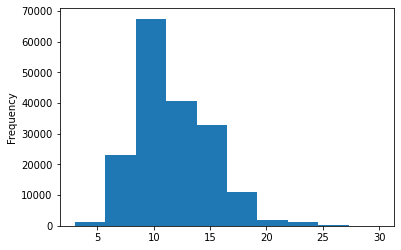

In [14]:
train_df.total_lines.plot.hist();

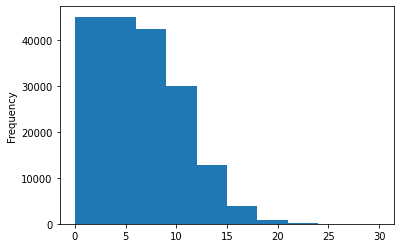

In [15]:
train_df.line_number.plot.hist();

In [16]:
# List of sentences (abstract text lines -> lists)
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preprocessing for the modelling 

In [18]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [19]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
# Labelling
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [21]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Defining the classes 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modellling

### model_1

In [23]:
# model_1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_1 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_1.fit(X=train_sentences,
            y=train_labels_encoded)

model_1.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [24]:
# Prediction on model_1
model_1_preds = model_1.predict(val_sentences)
model_1_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
# Evaluation 
model_1_results = calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## model_2 (with sequencing)

In [26]:
# model_2 data preprocessing

from tensorflow.keras import layers

# average length of sentence
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

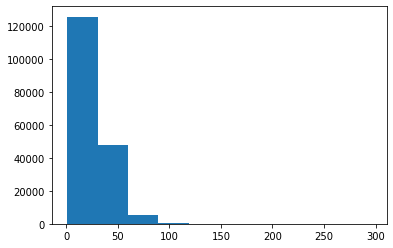

In [27]:
plt.hist(sentence_len, bins=10);

In [28]:
# check the % of sentences length between 0-50 & max sentence length
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len, max(sentence_len)

(55, 296)

#### Vectorization

In [29]:
# Section 3.2 states that the vocabulary size is 68,000 - https://arxiv.org/pdf/1710.06071.pdf
max_tokens = 68000 

In [30]:
# text vectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)
# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

# testing the text vectorizer
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
there were no significant differences in demographic characteristics , asa classification , length of surgery , estimated blood loss and the ci during surgery .

Length of text: 25

Vectorized text:
[[  61    9   33   37  102    5 1224  395 2128 1911  523    4  115  597
   107  264    3    2   50   52  115    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [31]:
# Number of words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Total number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Total number of words in vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
# Configuration 
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [33]:
# Embedding token layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name="token_embedding")

# View embedded token layer
print(f"before vectorization:\n{target_sentence}\n")
vectorized__sentence = text_vectorizer([target_sentence])
print(f"after vectorization:\n{vectorized__sentence}\n")
embedded_sentence = token_embed(vectorized__sentence)
print(f"after embedding:\n{embedded_sentence}\n")
print(f"shape after embedding: {embedded_sentence.shape}")

before vectorization:
there were no significant differences in demographic characteristics , asa classification , length of surgery , estimated blood loss and the ci during surgery .

after vectorization:
[[  61    9   33   37  102    5 1224  395 2128 1911  523    4  115  597
   107  264    3    2   50   52  115    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

after embedding:
[[[ 0.01341379  0.04481438  0.01588679 ... -0.0117395  -0.00790412
    0.01852873]
  [ 0.02011022 -0.04406952  0.01372776 ...  0.03429624  0.02385049
   -0.02464448]
  [-0.01025734 -0.00888624  0.03172824 ...  0.0184494   0.03616465
   -0.01937068]
  ...
  [ 0.04866513  0.01006328  0.03525047 ... -0.0032981   0.02187962
    0.04047606]
  [ 0.04866513  0.01006328  0.03525047 ... -0.0032981   0.02187962
    0.04047606]
  [ 0.04866513  0.01006328  0.03525047 ... -0.0032981   0.02187962
    

In [34]:
# Using Tensorflow dataset API for fast processing
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [35]:
# Convert the data into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [37]:
# Modelling Conv1D model_2

inputs= layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 52s 91ms/step - loss: 0.9259 - accuracy: 0.6360 - val_loss: 0.6910 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 51s 91ms/step - loss: 0.6649 - accuracy: 0.7540 - val_loss: 0.6448 - val_accuracy: 0.7673
Epoch 3/3
562/562 [==============================] - 51s 91ms/step - loss: 0.6213 - accuracy: 0.7747 - val_loss: 0.5947 - val_accuracy: 0.7846


In [38]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
# Evaluation
model_2.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5988 - accuracy: 0.7864


[0.5987774729728699, 0.7864093780517578]

In [40]:
# Predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4302985e-01, 1.8588908e-01, 8.4681794e-02, 2.4652679e-01,
        3.9872400e-02],
       [4.1563219e-01, 3.1297153e-01, 1.0353863e-02, 2.5301781e-01,
        8.0245230e-03],
       [1.6473052e-01, 1.0862859e-02, 3.4790861e-03, 8.2086515e-01,
        6.2383835e-05],
       ...,
       [6.5485783e-06, 5.9043226e-04, 1.2139605e-03, 1.8601128e-06,
        9.9818724e-01],
       [5.9975449e-02, 5.5618078e-01, 6.5442555e-02, 6.8651684e-02,
        2.4974959e-01],
       [2.1597144e-01, 5.9042013e-01, 5.7634220e-02, 7.8712925e-02,
        5.7261359e-02]], dtype=float32)

In [41]:
# Turning the prediction probabilities into classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
# Evaluating the results 
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.64093737587714,
 'f1': 0.7841784379669267,
 'precision': 0.7831568831969138,
 'recall': 0.7864093737587714}

## model_3 using feature extraction

In [44]:
# Pretrained model universal-sentence-encoder from hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Testing 
sample_sentence_for_training = random.choice(train_sentences)
print(f"Sample training sentence:\n{sample_sentence_for_training}\n")
use_embedded_sentence = tf_hub_embedding_layer([sample_sentence_for_training])
print(f"Sample sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated_output)...\n")
print(f"Length of the embedded sentence:\n{len(use_embedded_sentence[0])}")

Sample training sentence:
we undertook this study to determine whether oral magnesium supplementation modifies serum levels of high-sensitivity c-reactive protein ( hscrp ) in apparently healthy subjects with prediabetes and hypomagnesemia .

Sample sentence after embedding:
[-0.02839779  0.0260007  -0.03962677 -0.05834273  0.0263      0.0061941
  0.06408999 -0.02839705  0.04209505  0.04772086  0.08197236  0.06480646
  0.05788472  0.06544226 -0.08403166 -0.0343082  -0.08778667  0.02648667
  0.05623003 -0.06792317  0.01473383  0.02120501 -0.03598375  0.04757003
  0.00622224  0.0099448   0.04835591 -0.04160522 -0.0379659   0.00775846] (truncated_output)...

Length of the embedded sentence:
512


In [45]:
# Modelling model_3
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.fit(train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 0.9129 - accuracy: 0.6534 - val_loss: 0.7975 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7689 - accuracy: 0.7012 - val_loss: 0.7557 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7524 - accuracy: 0.7122 - val_loss: 0.7403 - val_accuracy: 0.7128


In [46]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
# Evaluate model_3
model_3.evaluate(valid_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.7415 - accuracy: 0.7135


[0.7414579391479492, 0.713458240032196]

In [48]:
# Predictions 
model_3_pred_probs = model_3.predict(valid_dataset)
model_3_pred_probs

array([[4.4507712e-01, 3.4393445e-01, 2.4809248e-03, 1.9900864e-01,
        9.4988495e-03],
       [3.4531966e-01, 5.0955242e-01, 3.2439879e-03, 1.3807851e-01,
        3.8053989e-03],
       [2.2812515e-01, 1.3852850e-01, 1.8403791e-02, 5.8045262e-01,
        3.4489986e-02],
       ...,
       [1.5836151e-03, 5.7425778e-03, 6.4713754e-02, 8.6891872e-04,
        9.2709112e-01],
       [4.8293928e-03, 4.9722888e-02, 2.0999403e-01, 1.8755810e-03,
        7.3357809e-01],
       [1.5188809e-01, 2.8464070e-01, 5.1179641e-01, 6.4735729e-03,
        4.5201238e-02]], dtype=float32)

In [49]:
# Convert the pred_probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [50]:
# Evaluating the results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 71.34582285184695,
 'f1': 0.7102243996494003,
 'precision': 0.7136256933594347,
 'recall': 0.7134582285184695}

# model_4 with character embeddings

In [52]:
# Function for character splitting
def split_character(text):
  return " ".join(list(text))

split_character(sample_sentence_for_training)  

'w e   u n d e r t o o k   t h i s   s t u d y   t o   d e t e r m i n e   w h e t h e r   o r a l   m a g n e s i u m   s u p p l e m e n t a t i o n   m o d i f i e s   s e r u m   l e v e l s   o f   h i g h - s e n s i t i v i t y   c - r e a c t i v e   p r o t e i n   (   h s c r p   )   i n   a p p a r e n t l y   h e a l t h y   s u b j e c t s   w i t h   p r e d i a b e t e s   a n d   h y p o m a g n e s e m i a   .'

In [53]:
# split the sequence 
train_char = [split_character(sentence) for sentence in train_sentences]
val_char = [split_character(sentence) for sentence in val_sentences]
test_char = [split_character(sentence) for sentence in test_sentences]
print(train_char[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [54]:
# Average length of the character
character_length = [len(sentence) for sentence in train_sentences]
mean_character_length = np.mean(character_length)
mean_character_length

149.3662574983337

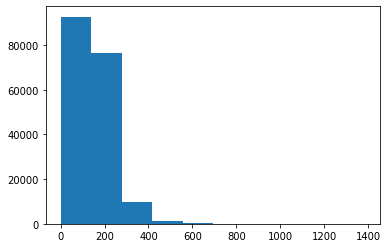

In [55]:
plt.hist(character_length, bins=10);

From the plot, we can observe that most of the sequences are between 0-200 characters long.

In [56]:
# for 95% of character length of sequences
output_seq_character_length = int(np.percentile(character_length, 95))
output_seq_character_length

290

In [57]:
# Vectorizing and character embeddings
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [60]:
# tokenizing the character
NUM_CHAR_TOKENS = len(alphabet) + 2
character_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                         output_sequence_length=output_seq_character_length,
                                         standardize="lower_and_strip_punctuation",
                                         name="character_vectorizer")
character_vectorizer.adapt(train_char)

# Sample of character vocabulary
character_vocab = character_vectorizer.get_vocabulary()
print(f"Total number of unique characters: {len(character_vocab)}")
print(f"10 most common characters: {character_vocab[:10]}")
print(f"10 least common characters: {character_vocab[-10:]}")

Total number of unique characters: 28
10 most common characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
10 least common characters: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [61]:
# Sample of character vectorizer
import random
sample_train_character = random.choice(train_char)
print(f" Text (in characters):\n{sample_train_character}")
print(f"\nCharacter length: {len(sample_train_character.split())}")
vectorized__character = character_vectorizer([sample_train_character])
print(f"\nCharacter Vectorized:\n{vectorized__character}")
print(f"\nVectorized character length: {len(vectorized__character[0])}")

 Text (in characters):
g i v e n   t h e   m u l t i p l e   d e m a n d s   m o t h e r s   f a c e   ,   a   f a i l u r e   t o   r e c o g n i s e   t h e i r   u n i q u e   n e e d s   i s   l i k e l y   t o   c o n t r i b u t e   t o   i n t e r g e n e r a t i o n a l   l e g a c i e s   o f   h o m e l e s s n e s s   a n d   m e n t a l   h e a l t h   p r o b l e m s   .

Character length: 155

Character Vectorized:
[[18  4 21  2  6  3 13  2 15 16 12  3  4 14 12  2 10  2 15  5  6 10  9 15
   7  3 13  2  8  9 17  5 11  2  5 17  5  4 12 16  8  2  3  7  8  2 11  7
  18  6  4  9  2  3 13  2  4  8 16  6  4 26 16  2  6  2  2 10  9  4  9 12
   4 23  2 12 19  3  7 11  7  6  3  8  4 22 16  3  2  3  7  4  6  3  2  8
  18  2  6  2  8  5  3  4  7  6  5 12 12  2 18  5 11  4  2  9  7 17 13  7
  15  2 12  2  9  9  6  2  9  9  5  6 10 15  2  6  3  5 12 13  2  5 12  3
  13 14  8  7 22 12  2 15  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [62]:
# Character embedding layer
character_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                   output_dim=25,
                                   mask_zero=False,
                                   name="character_embed")

# Sample
print(f"Character text before embeddings:\n{sample_train_character}\n")
character_embed_example = character_embed(character_vectorizer([sample_train_character]))
print(f"Embedded characters:\n{character_embed_example}\n")
print(f"Shape of embedded character: {character_embed_example.shape}")

Character text before embeddings:
g i v e n   t h e   m u l t i p l e   d e m a n d s   m o t h e r s   f a c e   ,   a   f a i l u r e   t o   r e c o g n i s e   t h e i r   u n i q u e   n e e d s   i s   l i k e l y   t o   c o n t r i b u t e   t o   i n t e r g e n e r a t i o n a l   l e g a c i e s   o f   h o m e l e s s n e s s   a n d   m e n t a l   h e a l t h   p r o b l e m s   .

Embedded characters:
[[[-0.00138418  0.00261258 -0.03166033 ...  0.00872849  0.03257681
   -0.00372161]
  [-0.04241898  0.04173816 -0.02953169 ... -0.01979643  0.03432314
    0.04573176]
  [-0.04287347  0.01445727 -0.03405704 ...  0.04374883 -0.02649885
    0.00600332]
  ...
  [-0.03154651 -0.0190884  -0.02809893 ...  0.0309983  -0.00087031
    0.00425646]
  [-0.03154651 -0.0190884  -0.02809893 ...  0.0309983  -0.00087031
    0.00425646]
  [-0.03154651 -0.0190884  -0.02809893 ...  0.0309983  -0.00087031
    0.00425646]]]

Shape of embedded character: (1, 290, 25)


In [64]:
# Modelling model_4 with Conv1D
inputs = layers.Input(shape=(1,), dtype="string")
character_vectors = character_vectorizer(inputs)
character_embeddings = character_embed(character_vectors)
x = layers.Conv1D(63, kernel_size=5, padding="same", activation="relu")(character_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_4_conv1D_character_embedding")
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Character dataset
train_character_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_character_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

model_4_history = model_4.fit(train_character_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_character_dataset)),
                              validation_data=val_character_dataset,
                              validation_steps=int(0.1 * len(val_character_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 50ms/step - loss: 1.2735 - accuracy: 0.4867 - val_loss: 1.0473 - val_accuracy: 0.5818
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 1.0079 - accuracy: 0.5969 - val_loss: 0.9446 - val_accuracy: 0.6263
Epoch 3/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9309 - accuracy: 0.6327 - val_loss: 0.8737 - val_accuracy: 0.6609


In [65]:
model_4.summary()

Model: "model_4_conv1D_character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 character_vectorizer (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 character_embed (Embedding)  (None, 290, 25)          1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 63)           7938      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 63)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (No

In [66]:
# model_4 evaluation
model_4.evaluate(val_character_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.8916 - accuracy: 0.6517


[0.891582190990448, 0.6516947150230408]

In [67]:
# Predictions
model_4_pred_probs = model_4.predict(val_character_dataset)
# Predictions to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
# Results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 65.16946908513174,
 'f1': 0.6424524702542843,
 'precision': 0.6452761439759128,
 'recall': 0.6516946908513174}

Not good enough at 65% accuracy, compared to model_1, model_2 & model_3.

# model_5 with pretrained tokens and character embeddings

In [75]:
# Tokens inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)
# Character inputs
character_inputs = layers.Input(shape=(1,), dtype=tf.string, name="character_input")
character_vectors = character_vectorizer(character_inputs)
character_embeddings = character_embed(character_vectors)
character_biLSTM = layers.Bidirectional(layers.LSTM(25))(character_embeddings)
character_model = tf.keras.Model(inputs=character_inputs,
                                 outputs=character_biLSTM)
# token & character concatenation 
token_character_concat = layers.Concatenate(name="token_character_hybrid")([token_model.output,
                                                                            character_model.output])
# Output layers
combined_dropout = layers.Dropout(0.5)(token_character_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_5 = tf.keras.Model(inputs=[token_model.input, character_model.input],
                         outputs=output_layer,
                         name="model_5_hybrid")
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Combining both of the training dataset & batching
train_character_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char))
train_character_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_character_token_dataset = tf.data.Dataset.zip((train_character_token_data, train_character_token_labels))
train_character_token_dataset = train_character_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Combining both of the validation dataset & batching
val_character_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))
val_character_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_character_token_dataset = tf.data.Dataset.zip((val_character_token_data, val_character_token_labels))
val_character_token_dataset = val_character_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit
model_5_history = model_5.fit(train_character_token_dataset,                           
                              steps_per_epoch=int(0.1 * len(train_character_token_dataset)),
                              epochs=3,
                              validation_data=val_character_token_dataset,
                              validation_steps=int(0.1 * len(val_character_token_dataset)))

Epoch 1/3
562/562 [==============================] - 119s 206ms/step - loss: 0.9541 - accuracy: 0.6224 - val_loss: 0.7769 - val_accuracy: 0.6958
Epoch 2/3
562/562 [==============================] - 98s 174ms/step - loss: 0.7908 - accuracy: 0.6962 - val_loss: 0.7098 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 96s 171ms/step - loss: 0.7685 - accuracy: 0.7074 - val_loss: 0.6889 - val_accuracy: 0.7437


In [76]:
model_5.summary()

Model: "model_5_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_input[0][0]']        
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]'

In [78]:
# model_5 evaluation
model_5.evaluate(val_character_token_dataset)

945/945 [==============================] - 34s 36ms/step - loss: 0.6920 - accuracy: 0.7376


[0.6920127272605896, 0.7375876903533936]

In [79]:
# model_5 predictions
model_5_pred_probs = model_5.predict(val_character_token_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 73.75877134913279,
 'f1': 0.7355227972040616,
 'precision': 0.7387452160402411,
 'recall': 0.7375877134913279}

model_5 performs better than model_4 

# model_6 with transfer learning and positional embeddings

In [80]:
 # EDA before modelling
 train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

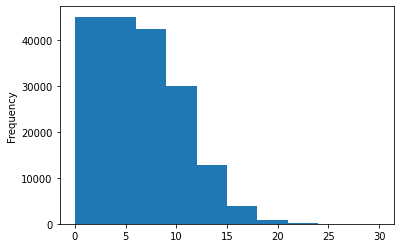

In [81]:
train_df.line_number.plot.hist();

In [82]:
# One hot encoding
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot, train_line_numbers_one_hot[:25]

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(25, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],

In [83]:
# Unique numbers of lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

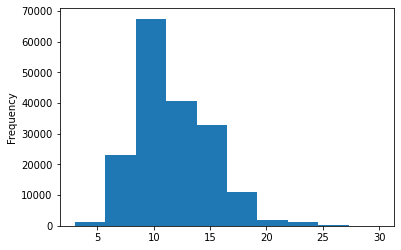

In [85]:
train_df.total_lines.plot.hist();

In [86]:
# total_lines value of 20 in %
np.percentile(train_df.total_lines, 98)

20.0

In [88]:
# One hot encoding the total_lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:15]

(TensorShape([180040, 20]), <tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [95]:
# Modelling model_6

# token
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf.tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)
# character
character_inputs = layers.Input(shape=(1,), dtype="string", name="character_inputs")
character_vectors = character_vectorizer(character_inputs)
character_embeddings = character_embed(character_vectors)
character_biLSTM = layers.Bidirectional(layers.LSTM(32))(character_embeddings)
character_model = tf.keras.Model(inputs=character_inputs,
                                 outputs=character_biLSTM)
# line numbers
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)
# total lines
total_lines_input = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)
# Concatenate token & character embeddings 
combined_embeddings = layers.Concatenate(name="token_character_hybrid_embedding")([token_model.output,
                                                                                   character_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
# Concatenate positional embeddings with token & character embeddings
z = layers.Concatenate(name="token_character_positional_embedding")([line_number_model.output,
                                                                     total_line_model.output,
                                                                     z])
# Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# model_6
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 character_model.input],
                         outputs=output_layer)

model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# training & validation dataset for x, y, z
train_pos_character_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                     train_total_lines_one_hot,
                                                                     train_sentences,
                                                                     train_char))
train_pos_character_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)
train_pos_character_token_dataset = tf.data.Dataset.zip((train_pos_character_token_data, train_pos_character_token_labels))
train_pos_character_token_dataset = train_pos_character_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation_dataset
val_pos_character_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                   val_total_lines_one_hot,
                                                                   val_sentences,
                                                                   val_char))
val_pos_character_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_character_token_dataset = tf.data.Dataset.zip((val_pos_character_token_data, val_pos_character_token_labels))
val_pos_character_token_dataset = val_pos_character_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit 
model_6_history = model_6.fit(train_pos_character_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_character_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_character_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_character_token_dataset)))

SyntaxError: ignored